In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import scipy.io

# Tensorflow
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



## Procesamiento de datos

### Manipulación de las cabeceras con los archivos .hea

In [3]:
file_path = 'C:/Users/Pedro/Documents/GitHub/TFM/WFDB_ChapmanShaoxing'
#file_path = 'C:/Users/ca01770/Documents/GitHub/TFM/WFDB_ChapmanShaoxing'
path = os.path.join(file_path, '*.hea')

In [21]:
# Lista para almacenar los datos extraídos
data_list = []

'''
En este bucle iteramos sobre cada archivo .hea 
en el directorio, el cual tiene la los datos
'''
for filepath in glob.glob(path):
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        subject_id = lines[0].split()[0]
        leads = int(lines[0].split()[1])
        samp_freq = int(lines[0].split()[2])
        samples = int(lines[0].split()[3])

        lead_info = []
        for i in range(1, leads + 1):
            parts = lines[i].split()
            lead_type = parts[-1]
            lead_gain = float(parts[2].split('/')[0])
            first_value = parts[5]
            last_value = parts[6]
            lead_info.append((lead_type, lead_gain, first_value, last_value))

        data_list.append({
            "path": os.path.splitext(filepath)[0],
            "filename": subject_id,
            "age": lines[13].split()[1],
            "sex": lines[14].split()[1],
            "diagnosis": lines[15].split()[1],
            "leads": str(leads),  # Convertir a cadena
            "frequency": str(samp_freq),  # Convertir a cadena
            "samples": str(samples),  # Convertir a cadena
            **{f"lead_{chr(65+i)}_type": info[0] for i, info in enumerate(lead_info)},
            **{f"lead_{chr(65+i)}_gain": str(info[1]) for i, info in enumerate(lead_info)},  # Convertir a cadena
            **{f"lead_{chr(65+i)}_first": info[2] for i, info in enumerate(lead_info)},
            **{f"lead_{chr(65+i)}_last": info[3] for i, info in enumerate(lead_info)}
        })

    except Exception as e:
        print(f"Error processing {filepath}: {e}")

# Crear un DataFrame y guardar en CSV
df = pd.DataFrame(data_list)
df.to_csv('extracted_ecg_data.csv', index=False)

In [4]:
# Carga del archivo CSV
data_path = 'extracted_ecg_data.csv'
data = pd.read_csv(data_path)

# Mostrar las primeras filas del DataFrame
print(data.head())
print(data.describe())

                                                path  ... lead_L_last
0  C:/Users/Pedro/Documents/GitHub/TFM/WFDB_Chapm...  ...       32579
1  C:/Users/Pedro/Documents/GitHub/TFM/WFDB_Chapm...  ...       31542
2  C:/Users/Pedro/Documents/GitHub/TFM/WFDB_Chapm...  ...       24967
3  C:/Users/Pedro/Documents/GitHub/TFM/WFDB_Chapm...  ...       -8125
4  C:/Users/Pedro/Documents/GitHub/TFM/WFDB_Chapm...  ...      -11358

[5 rows x 56 columns]
                age    leads  ...   lead_K_last   lead_L_last
count  10247.000000  10247.0  ...  10247.000000  10247.000000
mean      60.088123     12.0  ...    789.911877   1810.554113
std       17.024994      0.0  ...  19393.128099  19467.671204
min        4.000000     12.0  ... -32767.000000 -32762.000000
25%       50.000000     12.0  ... -16675.500000 -15901.500000
50%       62.000000     12.0  ...   1925.000000   4083.000000
75%       72.000000     12.0  ...  17882.000000  18913.500000
max       89.000000     12.0  ...  32763.000000  32767.000000

### Manipulación de las señales de ECG con los datos .mat

### Cargamos las señales

In [5]:
def load_mat_files(subject_ids, directory):
    ecg_data = []
    for subject_id in subject_ids:
        file_path = os.path.join(directory, f'{subject_id}.mat')
        mat_contents = scipy.io.loadmat(file_path)
        
        # Cogemos los valores del ECG almacenados en la varible 'val'
        ecg_signals = mat_contents['val']
        ecg_data.append(ecg_signals)
    return np.array(ecg_data)

ecg_signals = load_mat_files(data['filename'].tolist(), file_path)

### Preprocesamiento y Normalización de Señales de ECG

In [6]:
# Normalizar las señales
scaler = StandardScaler()
ecg_signals_normalized = scaler.fit_transform(ecg_signals.reshape(-1, ecg_signals.shape[-1])).reshape(ecg_signals.shape)

#### Redimensionamiento de las señales de ECG

In [7]:
# Verificar la forma actual de las señales de ECG
print(ecg_signals_normalized.shape)  # Shape --> num_samples, num_leads, signal_length

# Asegurar que la forma sea --> num_samples, signal_length, num_leads
ecg_signals_reshaped = ecg_signals_normalized.transpose((0, 2, 1))

'''
Problema con EfficientNet --> Espera 3 canales, por lo tanto 
duplicamos el canal de 1D que tenemos, tres veces
'''
# Redimensionar para añadir los canales y ajustarlo a EfficientNet
num_samples, signal_length, num_leads = ecg_signals_reshaped.shape
ecg_signals_reshaped = ecg_signals_reshaped.reshape(num_samples, signal_length, num_leads, 1)
#ecg_signals_rgb = np.tile(ecg_signals_reshaped, (1, 1, 1, 3))
ecg_signals_rgb = np.repeat(ecg_signals_reshaped, 3, axis=3)  # Usar repeat en lugar de tile para asegurar exactamente 3 canales


print(ecg_signals_rgb.shape)  # Shape --> num_samples, signal_length, num_leads, 3

(10247, 12, 5000)
(10247, 5000, 12, 3)


#### Transformaicón de etiquetas

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

# Transformamos las etiquetas
labels = data['diagnosis']
labels_split = labels.apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels_split)

# Print para verificar las etiquetas transfoormadas
print(labels_encoded.shape)  # Shape --> num_samples, num_labels


(10247, 54)


In [9]:
# Verificar las etiquetas originales y transformadas
print("Etiquetas originales:")
print(labels.head(10).tolist()) # aqui entiendo que el paciente puede tener más de un diagnóstico

print("\nEtiquetas transformadas (estan en formato bisnario):")
print(labels_encoded[:10])

# Verificar las clases únicas
print("\nClases únicas:")
print(mlb.classes_)

# Shape de la matriz de etiquetas transformadas
print("\nForma de la matriz de etiquetas:")
print(labels_encoded.shape)

# Mostrar algunas etiquetas originales y sus transformaciones
for i in range(10):
    print(f"Original: {labels.iloc[i]} -> Transformada: {labels_encoded[i]}")


Etiquetas originales:
['164889003,59118001,164934002', '426177001,164934002', '426177001', '164890007,429622005,428750005', '426177001', '164889003,164934002', '426783006', '426177001', '426177001', '426177001,55827005']

Etiquetas transformadas (estan en formato bisnario):
[[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

#### División del conjunto de entrenamiento

In [10]:
X_train, X_test, y_train, y_test = train_test_split(ecg_signals_rgb, labels_encoded, test_size=0.2, random_state=42)

# Verificamos las formas de los conjuntos de datos para ver si machean con los ya tratados y que se haya hecho el split de manera correcta
print(X_train.shape, X_test.shape) 
print(y_train.shape, y_test.shape)  

(8197, 5000, 12, 3) (2050, 5000, 12, 3)
(8197, 54) (2050, 54)


## Creación del modelo

### Definición del modelo

In [11]:
from tensorflow.keras.applications import EfficientNetB5 # Los `primeros valores son con la B0, vamos a probar con la última
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Creamos un modelo EfficientNet
def create_efficientnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    base_model = EfficientNetB5(include_top=False, weights=None, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x) # L2 regularization
    x = Dropout(0.4)(x) # Dropout layer
    outputs = Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(0.01))(x) # Aplicamos sigmoid por el multi-label
    model = Model(inputs=inputs, outputs=outputs)
    return model

num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 3)
print(f'input_shape: {input_shape}')

input_shape: (5000, 12, 3)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model = create_efficientnet(input_shape=input_shape, num_classes=num_classes) # Crear el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# Compilar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Guardamos el modelo
model.save('efficientnet7_ecg_model.h5')

Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2821 - loss: 1.1811

MemoryError: Unable to allocate 1.37 GiB for an array with shape (2050, 5000, 12, 3) and data type float32

NameError: name 'history' is not defined

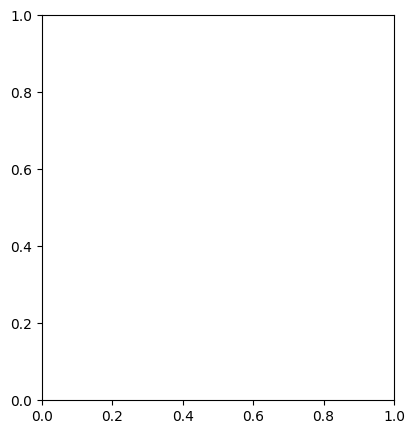

In [ ]:
import matplotlib.pyplot as plt

# Precisión
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
